In [1]:
import h5py
import numpy as np
import pandas as pd
import phenograph
import time
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn import manifold
%matplotlib inline
from sklearn.manifold import TSNE
import scanpy.api as sc
from collections import Counter
from sklearn.metrics import mutual_info_score
from sklearn.metrics import jaccard_similarity_score
from numba import jit
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

/cluster/work/bewi/members/tuncel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [11]:
@jit
def subsample(matrix, proportion=0.8):
    # proportion percentages are going to be kept the same
    n_samples_without_replacement = int(matrix.shape[0]*proportion)
    n_samples_with_replacement = matrix.shape[0]-n_samples_without_replacement
    subsampled = matrix.sample(n=n_samples_without_replacement, replace=False)
    subsampled2 = subsampled.sample(n=n_samples_with_replacement, replace=False)
    subsampled_final = pd.concat((subsampled, subsampled2), axis=0)
    np.random.shuffle(subsampled_final)
    return subsampled_final

def preprocess_zheng17(matrix):
    mask1 = (matrix.sum(axis=0) > 3)
    filtered_matrix = matrix [:,mask1]
    adata = sc.AnnData(filtered_matrix)
    sc.pp.normalize_per_cell(adata)
    filter_result = sc.pp.filter_genes_dispersion(adata.X, flavor='cell_ranger', n_top_genes=1000, log=False)
    mask2 = filter_result.gene_subset
    adata = adata[:, mask2]
    sc.pp.normalize_per_cell(adata)
    matrix = adata.X
    return matrix

def run_phenograph(matrix):
    current = time.time()
    communities, graph, Q = phenograph.cluster(matrix, n_jobs=8, k=100, primary_metric='euclidean')
    end = time.time()
    diff = end - current
    print(diff)
    return communities

@jit
def compute_jaccard(list1, list2):
    intersection = len(set(list1) & set(list2))
    union = len(set(list1) | set(list2))
    return intersection / union

In [4]:
input_file = '/cluster/home/mtuncel/sc-pipe/intermediate_files/coding_region_only_melanomaS2.h5'

In [5]:
h5f = h5py.File(input_file, 'r')

In [6]:
h5f = h5py.File(input_file, 'r')
matrix = h5f['matrix'][:]
barcodes = h5f['cell_attrs']['cell_names'].value
#cell_groups = h5f['cell_attrs']['cell_groups'].value

matrix = np.log1p(matrix)

In [7]:
h5f.close()

In [8]:
%%capture
preprocessed = preprocess_zheng17(matrix)
communities = run_phenograph(preprocessed)

In [9]:
original_df = pd.DataFrame(matrix)

In [12]:
original_df['labels'] = communities
original_df['original_index'] = original_df.index

## Assessment of cluster robustness

The evaluation procedure is described in the following publication: “Cluster-wise assessment of cluster stability,” Research Report 271, Dept. of Statistical Science, University College London, December 2006)
<br>

Given a clustering on a data set generated by a clustering method, the following principle is applied:
* Interpret the Jaccard coefficient (Jaccard, 1901) as a measure of similarity between two subsets of a set based on set membership.
* Resample new data sets from the original one (using various strategies) and apply the clustering method to them. 
* For every given cluster in the original clustering find the most similar cluster in the new clustering and record the
similarity value.
* Assess the cluster stability of every single cluster by the mean similarity taken over the resampled data sets.
###### Notes:
* Resampling is assessed by 100 bootstrap samples containing 80% of the unique cells.
* The clusters bigger than 10% of the number of all cells are selected for the evaluation. 

### Original sizes of clusters

In [29]:
communities.shape

(2495,)

In [13]:
dict(Counter(communities))

{0: 1228, 1: 277, 2: 255, 3: 204, 4: 168, 5: 167, 6: 106, 7: 90}

In [14]:
significant_clusters = []
size_criteria = len(communities)/10
for k,v in dict(Counter(communities)).items():
    if v>size_criteria:
        significant_clusters.append(k)
    else:
        pass

### The clusters that contain > 10% of all cells

In [15]:
significant_clusters

[0, 1, 2]

In [16]:
n_clusters = []
for j in tqdm(range(1,100)):
    ss = subsample(original_df)
    ss_index = ss.index.values
    ss = ss.drop(['labels','original_index'], axis=1)
    preprocessed_ss = preprocess_zheng17(ss.values)
    ss_communities = run_phenograph(preprocessed_ss)
    n_clusters.append(ss_communities)
    
    

  0%|          | 0/99 [00:00<?, ?it/s]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9856445789337158 seconds
Jaccard graph constructed in 1.2548205852508545 seconds
Wrote graph to binary file in 0.518164873123169 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.794406
Louvain completed 21 runs in 1.615809440612793 seconds
PhenoGraph complete in 5.489645481109619 seconds


  1%|          | 1/99 [00:09<14:48,  9.07s/it]

5.53315806388855
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9783885478973389 seconds
Jaccard graph constructed in 1.088470220565796 seconds
Wrote graph to binary file in 0.5121521949768066 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.789072
After 2 runs, maximum modularity is Q = 0.791751
Louvain completed 22 runs in 1.8204660415649414 seconds
PhenoGraph complete in 5.524540424346924 seconds


  2%|▏         | 2/99 [00:17<13:54,  8.60s/it]

5.568532705307007
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.7791624069213867 seconds
Jaccard graph constructed in 1.1332392692565918 seconds
Wrote graph to binary file in 0.5097992420196533 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.77881
After 2 runs, maximum modularity is Q = 0.780772
Louvain completed 22 runs in 1.8407716751098633 seconds
PhenoGraph complete in 5.376439094543457 seconds


  3%|▎         | 3/99 [00:25<13:30,  8.44s/it]

5.424711465835571
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9707348346710205 seconds
Jaccard graph constructed in 1.0774204730987549 seconds
Wrote graph to binary file in 0.5060305595397949 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.777603
After 9 runs, maximum modularity is Q = 0.778888
Louvain completed 29 runs in 2.333958625793457 seconds
PhenoGraph complete in 6.006628751754761 seconds


  4%|▍         | 4/99 [00:33<13:25,  8.48s/it]

6.049790859222412
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8687388896942139 seconds
Jaccard graph constructed in 1.0773494243621826 seconds
Wrote graph to binary file in 0.396578311920166 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78568
Louvain completed 21 runs in 1.666977882385254 seconds
PhenoGraph complete in 5.138242483139038 seconds


  5%|▌         | 5/99 [00:41<13:02,  8.33s/it]

5.193865776062012
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0744314193725586 seconds
Jaccard graph constructed in 1.2365670204162598 seconds
Wrote graph to binary file in 0.46341657638549805 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.786943
Louvain completed 21 runs in 1.689680814743042 seconds
PhenoGraph complete in 5.586682081222534 seconds


  6%|▌         | 6/99 [00:49<12:54,  8.32s/it]

5.628648042678833
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9847936630249023 seconds
Jaccard graph constructed in 1.241558313369751 seconds
Wrote graph to binary file in 0.4243156909942627 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.778567
After 3 runs, maximum modularity is Q = 0.782569
Louvain completed 23 runs in 1.888139009475708 seconds
PhenoGraph complete in 5.6548285484313965 seconds


  7%|▋         | 7/99 [00:58<12:49,  8.37s/it]

5.705897569656372
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4680795669555664 seconds
Jaccard graph constructed in 1.313596487045288 seconds
Wrote graph to binary file in 0.4605550765991211 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.783607
Louvain completed 21 runs in 1.6450245380401611 seconds
PhenoGraph complete in 5.010502099990845 seconds


  8%|▊         | 8/99 [01:06<12:34,  8.29s/it]

5.0539164543151855
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0746474266052246 seconds
Jaccard graph constructed in 1.139664649963379 seconds
Wrote graph to binary file in 0.47861599922180176 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784515
Louvain completed 21 runs in 1.6148643493652344 seconds
PhenoGraph complete in 5.4240806102752686 seconds


  9%|▉         | 9/99 [01:14<12:23,  8.26s/it]

5.466464281082153
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9824597835540771 seconds
Jaccard graph constructed in 1.1925995349884033 seconds
Wrote graph to binary file in 0.5617084503173828 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.788134
Louvain completed 21 runs in 1.7208454608917236 seconds
PhenoGraph complete in 5.599545478820801 seconds


 10%|█         | 10/99 [01:22<12:14,  8.26s/it]

5.643745422363281
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9756693840026855 seconds
Jaccard graph constructed in 1.2328310012817383 seconds
Wrote graph to binary file in 0.5097637176513672 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.786206
After 2 runs, maximum modularity is Q = 0.790352
Louvain completed 22 runs in 1.7918643951416016 seconds
PhenoGraph complete in 5.64022159576416 seconds


 11%|█         | 11/99 [01:30<12:07,  8.27s/it]

5.688446998596191
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8833019733428955 seconds
Jaccard graph constructed in 1.1224257946014404 seconds
Wrote graph to binary file in 0.48111963272094727 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.781881
Louvain completed 21 runs in 1.5629057884216309 seconds
PhenoGraph complete in 5.166423797607422 seconds


 12%|█▏        | 12/99 [01:38<11:57,  8.24s/it]

5.214939594268799
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.088865041732788 seconds
Jaccard graph constructed in 1.121147871017456 seconds
Wrote graph to binary file in 0.4682455062866211 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.779511
After 2 runs, maximum modularity is Q = 0.781104
Louvain completed 22 runs in 1.749840259552002 seconds
PhenoGraph complete in 5.540594816207886 seconds


 13%|█▎        | 13/99 [01:47<11:48,  8.24s/it]

5.585939168930054
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.19362211227417 seconds
Jaccard graph constructed in 1.0908534526824951 seconds
Wrote graph to binary file in 0.4784531593322754 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.774739
After 2 runs, maximum modularity is Q = 0.775818
After 22 runs, maximum modularity is Q = 0.776842
Louvain completed 42 runs in 3.3710083961486816 seconds
PhenoGraph complete in 7.2448461055755615 seconds


 14%|█▍        | 14/99 [01:56<11:49,  8.35s/it]

7.287620782852173
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9775993824005127 seconds
Jaccard graph constructed in 1.2245547771453857 seconds
Wrote graph to binary file in 0.39011597633361816 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.790335
Louvain completed 21 runs in 1.6464135646820068 seconds
PhenoGraph complete in 5.350166320800781 seconds


 15%|█▌        | 15/99 [02:04<11:38,  8.32s/it]

5.396417140960693
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8675470352172852 seconds
Jaccard graph constructed in 1.2708351612091064 seconds
Wrote graph to binary file in 0.4887106418609619 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.791766
After 11 runs, maximum modularity is Q = 0.792892
Louvain completed 31 runs in 2.236046075820923 seconds
PhenoGraph complete in 5.97688627243042 seconds


 16%|█▌        | 16/99 [02:13<11:30,  8.32s/it]

6.01999306678772
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.7724506855010986 seconds
Jaccard graph constructed in 1.1270484924316406 seconds
Wrote graph to binary file in 0.5047760009765625 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.789573
Louvain completed 21 runs in 1.5156543254852295 seconds
PhenoGraph complete in 5.028985261917114 seconds


 17%|█▋        | 17/99 [02:20<11:19,  8.29s/it]

5.072066783905029
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9658148288726807 seconds
Jaccard graph constructed in 1.1518847942352295 seconds
Wrote graph to binary file in 0.5066065788269043 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784768
After 21 runs, maximum modularity is Q = 0.785982
Louvain completed 41 runs in 2.927649974822998 seconds
PhenoGraph complete in 6.659364223480225 seconds


 18%|█▊        | 18/99 [02:30<11:15,  8.34s/it]

6.707069396972656
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8811192512512207 seconds
Jaccard graph constructed in 1.141071081161499 seconds
Wrote graph to binary file in 0.46393442153930664 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.773969
After 2 runs, maximum modularity is Q = 0.775027
After 3 runs, maximum modularity is Q = 0.776031
After 22 runs, maximum modularity is Q = 0.777277
Louvain completed 42 runs in 3.2385306358337402 seconds
PhenoGraph complete in 6.869595527648926 seconds


 19%|█▉        | 19/99 [02:39<11:11,  8.40s/it]

6.916430234909058
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9736220836639404 seconds
Jaccard graph constructed in 1.2005915641784668 seconds
Wrote graph to binary file in 0.6254565715789795 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.785519
After 7 runs, maximum modularity is Q = 0.786519
Louvain completed 27 runs in 2.1878092288970947 seconds
PhenoGraph complete in 6.109615325927734 seconds


 20%|██        | 20/99 [02:48<11:04,  8.41s/it]

6.151865005493164
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9684031009674072 seconds
Jaccard graph constructed in 1.1706159114837646 seconds
Wrote graph to binary file in 0.40548062324523926 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78579
After 4 runs, maximum modularity is Q = 0.787017
Louvain completed 24 runs in 1.912829875946045 seconds
PhenoGraph complete in 5.581499814987183 seconds


 21%|██        | 21/99 [02:56<10:54,  8.40s/it]

5.6241536140441895
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8597021102905273 seconds
Jaccard graph constructed in 1.1958668231964111 seconds
Wrote graph to binary file in 0.5601236820220947 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.793467
After 2 runs, maximum modularity is Q = 0.794731
Louvain completed 22 runs in 1.7738683223724365 seconds
PhenoGraph complete in 5.5515053272247314 seconds


 22%|██▏       | 22/99 [03:04<10:45,  8.39s/it]

5.5976011753082275
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8653619289398193 seconds
Jaccard graph constructed in 1.1476387977600098 seconds
Wrote graph to binary file in 0.5010268688201904 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.783321
Louvain completed 21 runs in 1.6573476791381836 seconds
PhenoGraph complete in 5.290604114532471 seconds


 23%|██▎       | 23/99 [03:12<10:36,  8.37s/it]

5.332381963729858
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9843266010284424 seconds
Jaccard graph constructed in 1.1486461162567139 seconds
Wrote graph to binary file in 0.5151972770690918 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.778981
Louvain completed 21 runs in 1.5315759181976318 seconds
PhenoGraph complete in 5.302238941192627 seconds


 24%|██▍       | 24/99 [03:20<10:26,  8.35s/it]

5.3459014892578125
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9776508808135986 seconds
Jaccard graph constructed in 1.1221346855163574 seconds
Wrote graph to binary file in 0.5139598846435547 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.781941
After 9 runs, maximum modularity is Q = 0.783145
Louvain completed 29 runs in 2.427065849304199 seconds
PhenoGraph complete in 6.160600423812866 seconds


 25%|██▌       | 25/99 [03:29<10:19,  8.37s/it]

6.203138113021851
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8827779293060303 seconds
Jaccard graph constructed in 1.1661100387573242 seconds
Wrote graph to binary file in 0.42386913299560547 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.785386
Louvain completed 21 runs in 1.7239573001861572 seconds
PhenoGraph complete in 5.318885564804077 seconds


 26%|██▋       | 26/99 [03:37<10:10,  8.36s/it]

5.361413478851318
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.869356632232666 seconds
Jaccard graph constructed in 1.2929046154022217 seconds
Wrote graph to binary file in 0.5915348529815674 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.775025
Louvain completed 21 runs in 1.6809194087982178 seconds
PhenoGraph complete in 5.57064151763916 seconds


 27%|██▋       | 27/99 [03:45<10:02,  8.37s/it]

5.617579936981201
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.7772009372711182 seconds
Jaccard graph constructed in 1.1121771335601807 seconds
Wrote graph to binary file in 0.5145878791809082 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.782656
Louvain completed 21 runs in 1.7286653518676758 seconds
PhenoGraph complete in 5.2529003620147705 seconds


 28%|██▊       | 28/99 [03:53<09:53,  8.35s/it]

5.3029749393463135
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8720011711120605 seconds
Jaccard graph constructed in 1.1506612300872803 seconds
Wrote graph to binary file in 0.43286657333374023 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.785683
Louvain completed 21 runs in 1.5912141799926758 seconds
PhenoGraph complete in 5.167990207672119 seconds


 29%|██▉       | 29/99 [04:01<09:43,  8.33s/it]

5.22053074836731
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.462667465209961 seconds
Jaccard graph constructed in 1.2112088203430176 seconds
Wrote graph to binary file in 0.46474480628967285 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.791081
Louvain completed 21 runs in 1.724707841873169 seconds
PhenoGraph complete in 4.980034112930298 seconds


 30%|███       | 30/99 [04:09<09:33,  8.31s/it]

5.020039319992065
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.6756598949432373 seconds
Jaccard graph constructed in 1.166856050491333 seconds
Wrote graph to binary file in 0.4711482524871826 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.781623
After 4 runs, maximum modularity is Q = 0.783958
Louvain completed 24 runs in 1.8946642875671387 seconds
PhenoGraph complete in 5.324991703033447 seconds


 31%|███▏      | 31/99 [04:17<09:24,  8.30s/it]

5.373625993728638
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4813170433044434 seconds
Jaccard graph constructed in 1.2009611129760742 seconds
Wrote graph to binary file in 0.4717886447906494 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.785354
Louvain completed 21 runs in 1.7422904968261719 seconds
PhenoGraph complete in 5.020630359649658 seconds


 32%|███▏      | 32/99 [04:24<09:14,  8.28s/it]

5.0606067180633545
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9730370044708252 seconds
Jaccard graph constructed in 1.183091402053833 seconds
Wrote graph to binary file in 0.4723324775695801 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784022
Louvain completed 21 runs in 1.7110998630523682 seconds
PhenoGraph complete in 5.456839323043823 seconds


 33%|███▎      | 33/99 [04:32<09:05,  8.27s/it]

5.5096824169158936
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0909698009490967 seconds
Jaccard graph constructed in 1.1497786045074463 seconds
Wrote graph to binary file in 0.48432087898254395 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.790995
Louvain completed 21 runs in 1.8040554523468018 seconds
PhenoGraph complete in 5.65161395072937 seconds


 34%|███▍      | 34/99 [04:41<08:57,  8.28s/it]

5.699778318405151
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.473414659500122 seconds
Jaccard graph constructed in 1.2273468971252441 seconds
Wrote graph to binary file in 0.47647619247436523 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.783415
Louvain completed 21 runs in 1.6934034824371338 seconds
PhenoGraph complete in 4.982278823852539 seconds


 35%|███▌      | 35/99 [04:49<08:48,  8.26s/it]

5.025697231292725
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.5860376358032227 seconds
Jaccard graph constructed in 1.2216706275939941 seconds
Wrote graph to binary file in 0.5958328247070312 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.793299
Louvain completed 21 runs in 1.8393526077270508 seconds
PhenoGraph complete in 5.36130952835083 seconds


 36%|███▋      | 36/99 [04:57<08:40,  8.25s/it]

5.415355920791626
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.5936894416809082 seconds
Jaccard graph constructed in 1.2852823734283447 seconds
Wrote graph to binary file in 0.4204094409942627 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.786399
After 2 runs, maximum modularity is Q = 0.787667
Louvain completed 22 runs in 1.9176998138427734 seconds
PhenoGraph complete in 5.336782217025757 seconds


 37%|███▋      | 37/99 [05:05<08:31,  8.25s/it]

5.394206285476685
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.091862916946411 seconds
Jaccard graph constructed in 1.3307669162750244 seconds
Wrote graph to binary file in 0.5245916843414307 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.775292
After 2 runs, maximum modularity is Q = 0.789064
Louvain completed 22 runs in 1.966801643371582 seconds
PhenoGraph complete in 6.050013303756714 seconds


 38%|███▊      | 38/99 [05:13<08:23,  8.26s/it]

6.102416515350342
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4730870723724365 seconds
Jaccard graph constructed in 1.1510326862335205 seconds
Wrote graph to binary file in 0.40430140495300293 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78018
Louvain completed 21 runs in 1.6208164691925049 seconds
PhenoGraph complete in 4.771247863769531 seconds


 39%|███▉      | 39/99 [05:21<08:14,  8.24s/it]

4.81105637550354
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.5640146732330322 seconds
Jaccard graph constructed in 1.235198736190796 seconds
Wrote graph to binary file in 0.4849853515625 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.787594
Louvain completed 21 runs in 1.660627841949463 seconds
PhenoGraph complete in 5.062304496765137 seconds


 40%|████      | 40/99 [05:29<08:05,  8.23s/it]

5.105614185333252
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.084709644317627 seconds
Jaccard graph constructed in 1.173980951309204 seconds
Wrote graph to binary file in 0.5103912353515625 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.789004
Louvain completed 21 runs in 1.683337926864624 seconds
PhenoGraph complete in 5.578241586685181 seconds


 41%|████▏     | 41/99 [05:37<07:57,  8.23s/it]

5.62172794342041
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4741499423980713 seconds
Jaccard graph constructed in 1.2260158061981201 seconds
Wrote graph to binary file in 0.4905738830566406 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78551
After 3 runs, maximum modularity is Q = 0.786982
Louvain completed 23 runs in 2.2254927158355713 seconds
PhenoGraph complete in 5.536416053771973 seconds


 42%|████▏     | 42/99 [05:45<07:49,  8.24s/it]

5.603168249130249
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.5724642276763916 seconds
Jaccard graph constructed in 1.163590431213379 seconds
Wrote graph to binary file in 0.4448263645172119 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784919
Louvain completed 21 runs in 1.599595069885254 seconds
PhenoGraph complete in 4.898131847381592 seconds


 43%|████▎     | 43/99 [05:53<07:40,  8.22s/it]

4.9487996101379395
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4707026481628418 seconds
Jaccard graph constructed in 1.300471544265747 seconds
Wrote graph to binary file in 0.4977583885192871 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784014
Louvain completed 21 runs in 1.7672083377838135 seconds
PhenoGraph complete in 5.148077011108398 seconds


 44%|████▍     | 44/99 [06:01<07:32,  8.22s/it]

5.187734127044678
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8790993690490723 seconds
Jaccard graph constructed in 1.1267201900482178 seconds
Wrote graph to binary file in 0.5105063915252686 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.794561
Louvain completed 21 runs in 1.7180352210998535 seconds
PhenoGraph complete in 5.350754976272583 seconds


 45%|████▌     | 45/99 [06:09<07:23,  8.22s/it]

5.400624990463257
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.5702617168426514 seconds
Jaccard graph constructed in 1.1822843551635742 seconds
Wrote graph to binary file in 0.4697422981262207 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.783333
Louvain completed 21 runs in 1.8781921863555908 seconds
PhenoGraph complete in 5.21329665184021 seconds


 46%|████▋     | 46/99 [06:17<07:15,  8.21s/it]

5.256258487701416
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3806986808776855 seconds
Jaccard graph constructed in 1.2106010913848877 seconds
Wrote graph to binary file in 0.4592278003692627 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.779473
After 4 runs, maximum modularity is Q = 0.780757
After 15 runs, maximum modularity is Q = 0.78198
Louvain completed 35 runs in 3.0833823680877686 seconds
PhenoGraph complete in 6.252233505249023 seconds


 47%|████▋     | 47/99 [06:26<07:07,  8.22s/it]

6.295572757720947
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9838316440582275 seconds
Jaccard graph constructed in 1.2666831016540527 seconds
Wrote graph to binary file in 0.5017695426940918 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.786786
Louvain completed 21 runs in 1.8289811611175537 seconds
PhenoGraph complete in 5.720658302307129 seconds


 48%|████▊     | 48/99 [06:34<06:59,  8.23s/it]

5.767789125442505
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.1826319694519043 seconds
Jaccard graph constructed in 1.2749571800231934 seconds
Wrote graph to binary file in 0.43301963806152344 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.776496
After 6 runs, maximum modularity is Q = 0.777731
Louvain completed 26 runs in 2.187653064727783 seconds
PhenoGraph complete in 6.193828582763672 seconds


 49%|████▉     | 49/99 [06:44<06:52,  8.25s/it]

6.249607801437378
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.678389072418213 seconds
Jaccard graph constructed in 1.441927194595337 seconds
Wrote graph to binary file in 0.6000316143035889 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78526
After 4 runs, maximum modularity is Q = 0.789194
Louvain completed 24 runs in 2.24980092048645 seconds
PhenoGraph complete in 6.11865496635437 seconds


 51%|█████     | 50/99 [06:52<06:44,  8.26s/it]

6.1619555950164795
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.573251485824585 seconds
Jaccard graph constructed in 1.2450268268585205 seconds
Wrote graph to binary file in 0.4594590663909912 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784929
Louvain completed 21 runs in 1.8906497955322266 seconds
PhenoGraph complete in 5.308449745178223 seconds


 52%|█████▏    | 51/99 [07:00<06:36,  8.25s/it]

5.360377550125122
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.579209804534912 seconds
Jaccard graph constructed in 1.287848711013794 seconds
Wrote graph to binary file in 0.5898120403289795 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.790219
After 5 runs, maximum modularity is Q = 0.791421
Louvain completed 25 runs in 2.0003230571746826 seconds
PhenoGraph complete in 5.5758068561553955 seconds


 53%|█████▎    | 52/99 [07:09<06:28,  8.26s/it]

5.6257569789886475
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.5863783359527588 seconds
Jaccard graph constructed in 1.2069423198699951 seconds
Wrote graph to binary file in 0.5281925201416016 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.786671
After 3 runs, maximum modularity is Q = 0.789019
Louvain completed 23 runs in 1.989957332611084 seconds
PhenoGraph complete in 5.427656412124634 seconds


 54%|█████▎    | 53/99 [07:17<06:19,  8.25s/it]

5.478048801422119
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.6864962577819824 seconds
Jaccard graph constructed in 1.204728364944458 seconds
Wrote graph to binary file in 0.5113661289215088 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78337
After 4 runs, maximum modularity is Q = 0.78437
Louvain completed 24 runs in 2.096346378326416 seconds
PhenoGraph complete in 5.618927240371704 seconds


 55%|█████▍    | 54/99 [07:25<06:11,  8.26s/it]

5.6775641441345215
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.5766608715057373 seconds
Jaccard graph constructed in 1.1766321659088135 seconds
Wrote graph to binary file in 0.5476133823394775 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.789904
After 6 runs, maximum modularity is Q = 0.791053
Louvain completed 26 runs in 2.2365691661834717 seconds
PhenoGraph complete in 5.662044048309326 seconds


 56%|█████▌    | 55/99 [07:34<06:03,  8.26s/it]

5.712486028671265
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.770850658416748 seconds
Jaccard graph constructed in 1.2224810123443604 seconds
Wrote graph to binary file in 0.5081441402435303 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.776963
Louvain completed 21 runs in 1.6558966636657715 seconds
PhenoGraph complete in 5.301756143569946 seconds


 57%|█████▋    | 56/99 [07:42<05:55,  8.26s/it]

5.349169492721558
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4684405326843262 seconds
Jaccard graph constructed in 1.1403617858886719 seconds
Wrote graph to binary file in 0.454479455947876 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784275
Louvain completed 21 runs in 1.743455410003662 seconds
PhenoGraph complete in 4.926924228668213 seconds


 58%|█████▊    | 57/99 [07:50<05:46,  8.25s/it]

4.9842612743377686
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.877474069595337 seconds
Jaccard graph constructed in 1.2106928825378418 seconds
Wrote graph to binary file in 0.5562634468078613 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.777409
After 2 runs, maximum modularity is Q = 0.779194
After 11 runs, maximum modularity is Q = 0.781864
Louvain completed 31 runs in 2.470196485519409 seconds
PhenoGraph complete in 6.243858814239502 seconds


 59%|█████▊    | 58/99 [07:59<05:38,  8.26s/it]

6.2993690967559814
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.6745872497558594 seconds
Jaccard graph constructed in 1.1886522769927979 seconds
Wrote graph to binary file in 0.47321557998657227 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.787474
After 3 runs, maximum modularity is Q = 0.788533
After 4 runs, maximum modularity is Q = 0.789877
Louvain completed 24 runs in 2.0649664402008057 seconds
PhenoGraph complete in 5.513137578964233 seconds


 60%|█████▉    | 59/99 [08:07<05:30,  8.26s/it]

5.556507587432861
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0923454761505127 seconds
Jaccard graph constructed in 1.2320821285247803 seconds
Wrote graph to binary file in 0.5135724544525146 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.781424
After 2 runs, maximum modularity is Q = 0.784803
Louvain completed 22 runs in 1.7885768413543701 seconds
PhenoGraph complete in 5.7396321296691895 seconds


 61%|██████    | 60/99 [08:15<05:22,  8.27s/it]

5.7946953773498535
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9877512454986572 seconds
Jaccard graph constructed in 1.1497647762298584 seconds
Wrote graph to binary file in 0.503300666809082 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.791449
Louvain completed 21 runs in 1.7260124683380127 seconds
PhenoGraph complete in 5.499775171279907 seconds


 62%|██████▏   | 61/99 [08:24<05:14,  8.27s/it]

5.55001425743103
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.6655654907226562 seconds
Jaccard graph constructed in 1.2828130722045898 seconds
Wrote graph to binary file in 0.5710504055023193 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78277
Louvain completed 21 runs in 1.7210109233856201 seconds
PhenoGraph complete in 5.353421211242676 seconds


 63%|██████▎   | 62/99 [08:32<05:05,  8.26s/it]

5.410402297973633
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.2860171794891357 seconds
Jaccard graph constructed in 1.304170846939087 seconds
Wrote graph to binary file in 0.536358118057251 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.782592
After 2 runs, maximum modularity is Q = 0.789657
Louvain completed 22 runs in 1.9927163124084473 seconds
PhenoGraph complete in 6.239748001098633 seconds


 64%|██████▎   | 63/99 [08:41<04:58,  8.28s/it]

6.283075571060181
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.888906478881836 seconds
Jaccard graph constructed in 1.3654921054840088 seconds
Wrote graph to binary file in 0.5159335136413574 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.790351
After 2 runs, maximum modularity is Q = 0.791454
After 3 runs, maximum modularity is Q = 0.792757
Louvain completed 23 runs in 2.1642251014709473 seconds
PhenoGraph complete in 6.055298089981079 seconds


 65%|██████▍   | 64/99 [08:50<04:50,  8.29s/it]

6.104304552078247
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.5749015808105469 seconds
Jaccard graph constructed in 1.2516441345214844 seconds
Wrote graph to binary file in 0.5057759284973145 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.778767
After 2 runs, maximum modularity is Q = 0.780553
After 4 runs, maximum modularity is Q = 0.781616
Louvain completed 24 runs in 2.2007510662078857 seconds
PhenoGraph complete in 5.662784576416016 seconds


 66%|██████▌   | 65/99 [08:58<04:41,  8.29s/it]

5.712161302566528
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4808952808380127 seconds
Jaccard graph constructed in 1.1728065013885498 seconds
Wrote graph to binary file in 0.4970841407775879 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784087
Louvain completed 21 runs in 1.6581034660339355 seconds
PhenoGraph complete in 4.946457386016846 seconds


 67%|██████▋   | 66/99 [09:06<04:33,  8.28s/it]

4.990123987197876
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9719135761260986 seconds
Jaccard graph constructed in 1.1644103527069092 seconds
Wrote graph to binary file in 0.5623483657836914 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.788792
After 4 runs, maximum modularity is Q = 0.79033
Louvain completed 24 runs in 2.1534948348999023 seconds
PhenoGraph complete in 5.984544992446899 seconds


 68%|██████▊   | 67/99 [09:15<04:25,  8.28s/it]

6.036870241165161
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.568964958190918 seconds
Jaccard graph constructed in 1.1514158248901367 seconds
Wrote graph to binary file in 0.40112948417663574 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.786992
Louvain completed 21 runs in 1.626551628112793 seconds
PhenoGraph complete in 4.867660284042358 seconds


 69%|██████▊   | 68/99 [09:22<04:16,  8.27s/it]

4.912416219711304
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.5624349117279053 seconds
Jaccard graph constructed in 1.387699842453003 seconds
Wrote graph to binary file in 0.5278239250183105 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.785743
After 2 runs, maximum modularity is Q = 0.787343
Louvain completed 22 runs in 1.873652696609497 seconds
PhenoGraph complete in 5.488364934921265 seconds


 70%|██████▉   | 69/99 [09:30<04:08,  8.27s/it]

5.5365846157073975
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.1771113872528076 seconds
Jaccard graph constructed in 1.2333104610443115 seconds
Wrote graph to binary file in 0.5511224269866943 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.769928
Louvain completed 21 runs in 1.7201120853424072 seconds
PhenoGraph complete in 5.799170732498169 seconds


 71%|███████   | 70/99 [09:39<04:00,  8.28s/it]

5.844008207321167
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.971473217010498 seconds
Jaccard graph constructed in 1.208240270614624 seconds
Wrote graph to binary file in 0.5413837432861328 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.77875
After 2 runs, maximum modularity is Q = 0.779842
Louvain completed 22 runs in 1.786036491394043 seconds
PhenoGraph complete in 5.620228290557861 seconds


 72%|███████▏  | 71/99 [09:47<03:51,  8.27s/it]

5.661393165588379
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0866312980651855 seconds
Jaccard graph constructed in 1.1281678676605225 seconds
Wrote graph to binary file in 0.523644208908081 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.790866
After 2 runs, maximum modularity is Q = 0.792028
Louvain completed 22 runs in 1.9502065181732178 seconds
PhenoGraph complete in 5.807629823684692 seconds


 73%|███████▎  | 72/99 [09:55<03:43,  8.28s/it]

5.851268291473389
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9701666831970215 seconds
Jaccard graph constructed in 1.106910228729248 seconds
Wrote graph to binary file in 0.5372958183288574 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.786951
Louvain completed 21 runs in 1.7038884162902832 seconds
PhenoGraph complete in 5.429868221282959 seconds


 74%|███████▎  | 73/99 [10:04<03:35,  8.28s/it]

5.6566078662872314
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2675271034240723 seconds
Jaccard graph constructed in 1.13106369972229 seconds
Wrote graph to binary file in 0.5084207057952881 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.781726
Louvain completed 21 runs in 1.7277567386627197 seconds
PhenoGraph complete in 4.744084596633911 seconds


 75%|███████▍  | 74/99 [10:11<03:26,  8.26s/it]

4.79066801071167
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8763020038604736 seconds
Jaccard graph constructed in 1.1847314834594727 seconds
Wrote graph to binary file in 0.5252270698547363 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.782269
Louvain completed 21 runs in 1.9664933681488037 seconds
PhenoGraph complete in 5.664186239242554 seconds


 76%|███████▌  | 75/99 [10:19<03:18,  8.26s/it]

5.70328950881958
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.079836845397949 seconds
Jaccard graph constructed in 1.1309924125671387 seconds
Wrote graph to binary file in 0.5283246040344238 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.780668
Louvain completed 21 runs in 1.6785473823547363 seconds
PhenoGraph complete in 5.534373760223389 seconds


 77%|███████▋  | 76/99 [10:27<03:09,  8.26s/it]

5.574676990509033
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.873427391052246 seconds
Jaccard graph constructed in 1.1186892986297607 seconds
Wrote graph to binary file in 0.45588159561157227 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.777263
After 2 runs, maximum modularity is Q = 0.778833
Louvain completed 22 runs in 1.8828644752502441 seconds
PhenoGraph complete in 5.449882984161377 seconds


 78%|███████▊  | 77/99 [10:35<03:01,  8.26s/it]

5.498813152313232
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.570857048034668 seconds
Jaccard graph constructed in 1.2122690677642822 seconds
Wrote graph to binary file in 0.4683842658996582 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.781921
After 12 runs, maximum modularity is Q = 0.783099
Louvain completed 32 runs in 2.6793861389160156 seconds
PhenoGraph complete in 6.046627044677734 seconds


 79%|███████▉  | 78/99 [10:44<02:53,  8.26s/it]

6.096649646759033
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.6705973148345947 seconds
Jaccard graph constructed in 1.101567268371582 seconds
Wrote graph to binary file in 0.5100252628326416 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78931
Louvain completed 21 runs in 1.5690526962280273 seconds
PhenoGraph complete in 4.964799165725708 seconds


 80%|███████▉  | 79/99 [10:51<02:45,  8.25s/it]

5.009345769882202
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.5662739276885986 seconds
Jaccard graph constructed in 1.1172363758087158 seconds
Wrote graph to binary file in 0.4693927764892578 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.786606
Louvain completed 21 runs in 1.5086519718170166 seconds
PhenoGraph complete in 4.780245780944824 seconds


 81%|████████  | 80/99 [10:59<02:36,  8.24s/it]

4.828487157821655
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.763495683670044 seconds
Jaccard graph constructed in 1.1485481262207031 seconds
Wrote graph to binary file in 0.4879298210144043 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.785952
After 2 runs, maximum modularity is Q = 0.787242
After 3 runs, maximum modularity is Q = 0.788768
Louvain completed 23 runs in 1.9928128719329834 seconds
PhenoGraph complete in 5.506515026092529 seconds


 82%|████████▏ | 81/99 [11:07<02:28,  8.24s/it]

5.553546190261841
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2752022743225098 seconds
Jaccard graph constructed in 1.214949369430542 seconds
Wrote graph to binary file in 0.44761180877685547 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.787683
After 3 runs, maximum modularity is Q = 0.789058
Louvain completed 23 runs in 1.85581636428833 seconds
PhenoGraph complete in 4.916089057922363 seconds


 83%|████████▎ | 82/99 [11:15<02:19,  8.23s/it]

4.962547063827515
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8674876689910889 seconds
Jaccard graph constructed in 1.230994462966919 seconds
Wrote graph to binary file in 0.5724754333496094 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.781713
After 2 runs, maximum modularity is Q = 0.782791
Louvain completed 22 runs in 1.9099054336547852 seconds
PhenoGraph complete in 5.706174850463867 seconds


 84%|████████▍ | 83/99 [11:23<02:11,  8.23s/it]

5.749948978424072
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.078950881958008 seconds
Jaccard graph constructed in 1.2373542785644531 seconds
Wrote graph to binary file in 0.5666344165802002 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.776615
After 2 runs, maximum modularity is Q = 0.777668
Louvain completed 22 runs in 1.92399263381958 seconds
PhenoGraph complete in 5.936113595962524 seconds


 85%|████████▍ | 84/99 [11:31<02:03,  8.24s/it]

5.980700969696045
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.6720263957977295 seconds
Jaccard graph constructed in 1.2017889022827148 seconds
Wrote graph to binary file in 0.5046720504760742 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.793456
Louvain completed 21 runs in 1.6731741428375244 seconds
PhenoGraph complete in 5.168894529342651 seconds


 86%|████████▌ | 85/99 [11:39<01:55,  8.23s/it]

5.221214532852173
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.5804274082183838 seconds
Jaccard graph constructed in 1.2416965961456299 seconds
Wrote graph to binary file in 0.6369423866271973 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784461
After 2 runs, maximum modularity is Q = 0.785491
Louvain completed 22 runs in 1.8188951015472412 seconds
PhenoGraph complete in 5.453631639480591 seconds


 87%|████████▋ | 86/99 [11:48<01:47,  8.23s/it]

5.502504110336304
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9811208248138428 seconds
Jaccard graph constructed in 1.1823420524597168 seconds
Wrote graph to binary file in 0.5705528259277344 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.782274
Louvain completed 21 runs in 1.7331278324127197 seconds
PhenoGraph complete in 5.598248243331909 seconds


 88%|████████▊ | 87/99 [11:56<01:38,  8.24s/it]

5.647576332092285
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4790737628936768 seconds
Jaccard graph constructed in 1.1115994453430176 seconds
Wrote graph to binary file in 0.5796306133270264 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784436
Louvain completed 21 runs in 1.890132188796997 seconds
PhenoGraph complete in 5.187090158462524 seconds


 89%|████████▉ | 88/99 [12:04<01:30,  8.23s/it]

5.238917350769043
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.7734758853912354 seconds
Jaccard graph constructed in 1.1774592399597168 seconds
Wrote graph to binary file in 0.49562716484069824 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.790692
After 15 runs, maximum modularity is Q = 0.791941
Louvain completed 35 runs in 2.615750789642334 seconds
PhenoGraph complete in 6.184173345565796 seconds


 90%|████████▉ | 89/99 [12:13<01:22,  8.24s/it]

6.2325639724731445
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.7703230381011963 seconds
Jaccard graph constructed in 1.1634912490844727 seconds
Wrote graph to binary file in 0.5987200736999512 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.782737
After 2 runs, maximum modularity is Q = 0.784601
After 14 runs, maximum modularity is Q = 0.785729
Louvain completed 34 runs in 2.652090549468994 seconds
PhenoGraph complete in 6.3082263469696045 seconds


 91%|█████████ | 90/99 [12:22<01:14,  8.24s/it]

6.361247777938843
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.783376932144165 seconds
Jaccard graph constructed in 1.2372338771820068 seconds
Wrote graph to binary file in 0.5845036506652832 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.787622
Louvain completed 21 runs in 1.56166410446167 seconds
PhenoGraph complete in 5.297133684158325 seconds


 92%|█████████▏| 91/99 [12:29<01:05,  8.24s/it]

5.340736389160156
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0735833644866943 seconds
Jaccard graph constructed in 1.2025370597839355 seconds
Wrote graph to binary file in 0.591559648513794 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.770197
After 2 runs, maximum modularity is Q = 0.773397
After 3 runs, maximum modularity is Q = 0.775584
Louvain completed 23 runs in 1.8991189002990723 seconds
PhenoGraph complete in 5.886265277862549 seconds


 93%|█████████▎| 92/99 [12:38<00:57,  8.25s/it]

5.930248975753784
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.973393440246582 seconds
Jaccard graph constructed in 1.1808087825775146 seconds
Wrote graph to binary file in 0.47784900665283203 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.793419
After 7 runs, maximum modularity is Q = 0.794424
Louvain completed 27 runs in 2.1812853813171387 seconds
PhenoGraph complete in 5.966120719909668 seconds


 94%|█████████▍| 93/99 [12:47<00:49,  8.25s/it]

6.009160995483398
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.871791124343872 seconds
Jaccard graph constructed in 1.172309160232544 seconds
Wrote graph to binary file in 0.5701212882995605 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.776742
After 2 runs, maximum modularity is Q = 0.778561
Louvain completed 22 runs in 1.7664024829864502 seconds
PhenoGraph complete in 5.508258819580078 seconds


 95%|█████████▍| 94/99 [12:55<00:41,  8.25s/it]

5.546385288238525
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0683891773223877 seconds
Jaccard graph constructed in 1.1516146659851074 seconds
Wrote graph to binary file in 0.542414665222168 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.781311
Louvain completed 21 runs in 1.710479497909546 seconds
PhenoGraph complete in 5.597244739532471 seconds


 96%|█████████▌| 95/99 [13:03<00:32,  8.24s/it]

5.636025667190552
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.864807367324829 seconds
Jaccard graph constructed in 1.1427085399627686 seconds
Wrote graph to binary file in 0.563124418258667 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.783667
After 12 runs, maximum modularity is Q = 0.78528
Louvain completed 32 runs in 2.4902055263519287 seconds
PhenoGraph complete in 6.183276414871216 seconds


 97%|█████████▋| 96/99 [13:11<00:24,  8.25s/it]

6.235838890075684
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9804296493530273 seconds
Jaccard graph constructed in 1.1290359497070312 seconds
Wrote graph to binary file in 0.47005605697631836 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.786919
Louvain completed 21 runs in 1.5905952453613281 seconds
PhenoGraph complete in 5.2877538204193115 seconds


 98%|█████████▊| 97/99 [13:19<00:16,  8.24s/it]

5.328426122665405
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.868502140045166 seconds
Jaccard graph constructed in 1.1941015720367432 seconds
Wrote graph to binary file in 0.585402250289917 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.788867
After 3 runs, maximum modularity is Q = 0.790091
Louvain completed 23 runs in 1.9209802150726318 seconds
PhenoGraph complete in 5.68221378326416 seconds


 99%|█████████▉| 98/99 [13:27<00:08,  8.24s/it]

5.724938631057739
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3807966709136963 seconds
Jaccard graph constructed in 1.1874582767486572 seconds
Wrote graph to binary file in 0.47399449348449707 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78366
Louvain completed 21 runs in 1.7399203777313232 seconds
PhenoGraph complete in 4.896265268325806 seconds


100%|██████████| 99/99 [13:35<00:00,  8.24s/it]

4.9349892139434814


In [22]:
n_clusters_df = pd.DataFrame(n_clusters)

In [33]:
n_clusters_df

,0,1,2,3,4,5,6,7,8,9,...,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494
0,1,0,0,0,0,0,1,4,6,6,...,0,0,3,6,0,4,3,2,5,2
1,5,0,1,0,0,0,5,6,1,2,...,2,5,3,1,0,4,0,0,1,0
2,1,7,7,1,1,0,3,3,2,0,...,5,4,6,1,5,0,2,2,0,0
3,1,3,0,2,4,3,4,2,1,4,...,0,0,0,6,0,0,2,2,4,0
4,0,1,3,5,1,0,0,3,0,2,...,0,4,0,1,3,1,0,7,1,5
5,0,2,2,0,6,0,0,3,2,4,...,4,7,1,0,0,0,6,2,5,0
6,5,3,0,3,1,0,0,2,1,0,...,0,4,7,1,0,0,4,1,0,1
7,3,4,0,2,0,0,0,7,0,2,...,1,1,6,1,0,1,6,6,0,0
8,4,0,0,0,0,6,0,0,3,0,...,3,7,0,2,0,1,0,3,3,0
9,0,3,1,0,1,0,5,0,0,5,...,1,3,1,6,1,0,6,0,7,0


In [34]:
grouped = n_clusters_df.T.apply(lambda x: dict(Counter(x)), axis=0)

In [43]:
def n_big_ones(kv_pair):
    significant_clusters = []
    size_criteria = len(communities)/10
    for k,v in kv_pair.items():
        if v>size_criteria:
            significant_clusters.append(k)
        else:
            pass
    return len(significant_clusters)

In [45]:
size_criteria = len(communities)/10
hist_sizes = grouped.apply(n_big_ones)

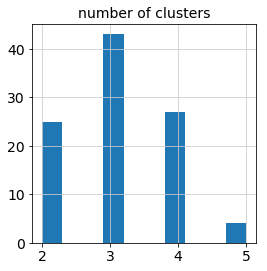

In [48]:

plt.hist(hist_sizes, color=None)
plt.title('number of clusters')